#notebook setup

In [1]:
!pip install google-auth --upgrade
!pip install grpcio --upgrade

Requirement already up-to-date: google-auth in /usr/local/lib/python3.6/dist-packages (1.10.0)
Requirement already up-to-date: grpcio in /usr/local/lib/python3.6/dist-packages (1.26.0)


In [2]:
!pip install -qq tf-nightly-gpu-2.0-preview

     |████████████████████████████████| 395.5MB 40kB/s 
     |████████████████████████████████| 3.8MB 28.5MB/s 
     |████████████████████████████████| 450kB 35.3MB/s 


In [3]:
import tensorflow as tf
print(tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.0.0-dev20191002
Found GPU at: /device:GPU:0


In [0]:
import sys
try:
    import ujson as json
except ImportError:
    try:
        import simplejson as json
    except ImportError:
        import json

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.preprocessing import MinMaxScaler
import pywt
import os
from PIL import Image
# import tensorflow as tf
from glob import glob

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model,load_model,Sequential

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

def plot_hist(input_history, filename):
  import os

  folder = ['acc', 'loss']

  directory = cwd + '/model_performance/'

  for f in folder:
    if not os.path.exists(directory + f):
      os.makedirs(directory + f)

  # summarize history for accuracy
  # fig, ax = plt.subplots(1,2)
  # plt.subplots_adjust(right=2)

  plt.plot(input_history.history['accuracy'])
  plt.plot(input_history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  plt.savefig(cwd+'/model_performance/acc/' + filename + '.jpg')
  plt.show()
  
  # summarize history for loss
  plt.plot(input_history.history['loss'])
  plt.plot(input_history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  
  plt.savefig(cwd+'/model_performance/loss/' + filename + '.jpg')

# Data prep

In [7]:
%cd drive/'My Drive/lhc_durham'
!pwd

/content/drive/My Drive/lhc_durham
/content/drive/My Drive/lhc_durham


In [8]:
img_folder = '/filtered_images'
!ls 'filtered_images'

0  1  2


class 0 : DYjets
class 1 : TTjets
class 2 : Wjets

## Train val size setting

In [9]:
cwd = os.getcwd()
img_path = cwd + img_folder

train_val_size = 1200

df = {}
data = []
for idx, x in enumerate(os.listdir(img_path)):
  if x.isdigit() and idx < 3:
    for idx2, pic in enumerate(os.listdir(img_path+'/'+str(x))):
      if idx2 < train_val_size:
        data.append((img_path+ '/' + x + '/' + pic , x))

df = pd.DataFrame(data, columns=['filename', 'class'])
df['class'] = df['class'].astype(int)
#shuffle
df = df.sample(frac=1).reset_index(drop=True)

print(df.head())
print(len(df))
df.dtypes

                                            filename  class
0  /content/drive/My Drive/lhc_durham/filtered_im...      2
1  /content/drive/My Drive/lhc_durham/filtered_im...      1
2  /content/drive/My Drive/lhc_durham/filtered_im...      1
3  /content/drive/My Drive/lhc_durham/filtered_im...      0
4  /content/drive/My Drive/lhc_durham/filtered_im...      1
3600


filename    object
class        int64
dtype: object

In [10]:
from collections import Counter
cnt = Counter(df['class'])
cnt

Counter({0: 1200, 1: 1200, 2: 1200})

In [11]:
# Split into train and validation sets
train_percentage = .8
val_percentage = 0.1
test_percentage = 0.1

train_length = int(len(df) * train_percentage)
df_train = df[:train_length]

val_length = int(len(df) * val_percentage)
df_val = df[train_length : train_length+val_length]

test_length = int(len(df) * test_percentage)
df_test = df[ train_length + val_length : ]

# shuffle 
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)

df_list = [df_train, df_val, df_test]
for df_part in df_list:
  print(len(df_part))

2880
360
360


#### image parsing

In [0]:
# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.
img_rows, img_cols = 200,200
num_classes = len(set(df['class']))
batch_size = 120

def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string)
  image_resized = tf.image.resize(image_decoded, [img_rows, img_cols])
  image_resized = tf.ensure_shape(image_resized ,shape=(img_rows, img_cols,3))
  label = tf.one_hot(label, num_classes)
  return image_resized, label

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_train['filename'].values, tf.string),
                                                    tf.cast(df_train['class'].values, tf.int32) ))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.shuffle(5000)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

In [0]:
valid_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_val['filename'].values, tf.string),
                                                    tf.cast(df_val['class'].values, tf.int32) ))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.shuffle(5000)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(batch_size, drop_remainder=True)

In [0]:
test_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_test['filename'].values, tf.string),
                                                    tf.cast(df_test['class'].values, tf.int32) ))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.shuffle(5000)
test_dataset = test_dataset.repeat()
test_dataset = test_dataset.batch(batch_size, drop_remainder=True)

In [16]:
train_dataset

<BatchDataset shapes: ((120, 200, 200, 3), (120, 3)), types: (tf.float32, tf.float32)>

# InceptionV3

## Entirely frozen

In [0]:
base_incepv3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(200, 200, 3),pooling=None)

In [0]:
# add a global spatial average pooling layer
x = base_incepv3.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 3 classes
predictions = Dense(3, activation='softmax')(x)

In [0]:
# this is the model we will train
base_incepv3_model = Model(inputs=base_incepv3.input, outputs=predictions)

In [86]:
for layer in base_incepv3.layers:
    print(layer.name)
    layer.trainable = False

input_6
conv2d_470
batch_normalization_470
activation_470
conv2d_471
batch_normalization_471
activation_471
conv2d_472
batch_normalization_472
activation_472
max_pooling2d_20
conv2d_473
batch_normalization_473
activation_473
conv2d_474
batch_normalization_474
activation_474
max_pooling2d_21
conv2d_478
batch_normalization_478
activation_478
conv2d_476
conv2d_479
batch_normalization_476
batch_normalization_479
activation_476
activation_479
average_pooling2d_45
conv2d_475
conv2d_477
conv2d_480
conv2d_481
batch_normalization_475
batch_normalization_477
batch_normalization_480
batch_normalization_481
activation_475
activation_477
activation_480
activation_481
mixed0
conv2d_485
batch_normalization_485
activation_485
conv2d_483
conv2d_486
batch_normalization_483
batch_normalization_486
activation_483
activation_486
average_pooling2d_46
conv2d_482
conv2d_484
conv2d_487
conv2d_488
batch_normalization_482
batch_normalization_484
batch_normalization_487
batch_normalization_488
activation_482
acti

In [87]:
for layer in base_incepv3_model.layers:
    print(layer.name,' Trainable =',layer.trainable)

input_6  Trainable = False
conv2d_470  Trainable = False
batch_normalization_470  Trainable = False
activation_470  Trainable = False
conv2d_471  Trainable = False
batch_normalization_471  Trainable = False
activation_471  Trainable = False
conv2d_472  Trainable = False
batch_normalization_472  Trainable = False
activation_472  Trainable = False
max_pooling2d_20  Trainable = False
conv2d_473  Trainable = False
batch_normalization_473  Trainable = False
activation_473  Trainable = False
conv2d_474  Trainable = False
batch_normalization_474  Trainable = False
activation_474  Trainable = False
max_pooling2d_21  Trainable = False
conv2d_478  Trainable = False
batch_normalization_478  Trainable = False
activation_478  Trainable = False
conv2d_476  Trainable = False
conv2d_479  Trainable = False
batch_normalization_476  Trainable = False
batch_normalization_479  Trainable = False
activation_476  Trainable = False
activation_479  Trainable = False
average_pooling2d_45  Trainable = False
conv2

In [0]:
opt = tf.keras.optimizers.Adam(lr=0.001)
# compile the model (should be done *after* setting layers to non-trainable)
base_incepv3_model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

#### fitting the model

In [89]:
train_steps = int(len(df_train)/batch_size) #total trains set / batch_size
val_steps = int(len(df_val)/batch_size)

print('train steps:',train_steps)
print('val steps:',val_steps)
epochs = 50

#es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=15)

incepv3_model_filepath = 'entirely_frozen_incepv3.h5'
mcp = ModelCheckpoint(incepv3_model_filepath, monitor='accuracy', save_best_only=True, mode='max')

### Train the model with validation 
entirely_frozen_incepv3_history = base_incepv3_model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks= [#es, 
                               mcp])

train steps: 24
val steps: 3
Train for 24 steps, validate for 3 steps
Epoch 1/50
24/24 [==============================] - 36s 2s/step - loss: 0.9423 - accuracy: 0.5278 - val_loss: 22.4424 - val_accuracy: 0.3444
Epoch 2/50
24/24 [==============================] - 30s 1s/step - loss: 0.7155 - accuracy: 0.6670 - val_loss: 21.8878 - val_accuracy: 0.3222
Epoch 3/50
24/24 [==============================] - 25s 1s/step - loss: 0.6828 - accuracy: 0.6854 - val_loss: 19.1091 - val_accuracy: 0.3389
Epoch 4/50
24/24 [==============================] - 23s 969ms/step - loss: 0.6116 - accuracy: 0.7375 - val_loss: 37.2056 - val_accuracy: 0.2889
Epoch 5/50
24/24 [==============================] - 23s 946ms/step - loss: 0.5714 - accuracy: 0.7441 - val_loss: 32.3117 - val_accuracy: 0.3222
Epoch 6/50
24/24 [==============================] - 23s 968ms/step - loss: 0.5386 - accuracy: 0.7747 - val_loss: 36.6195 - val_accuracy: 0.2972
Epoch 7/50
24/24 [==============================] - 23s 973ms/step - loss: 

#### testing the model

In [90]:
test_steps = int(len(df_test)/batch_size)

metrics = base_incepv3_model.evaluate(test_dataset,
                   steps = test_steps)
print("model accuracy:",metrics[1])

3/3 [==============================] - 2s 765ms/step - loss: 83.6821 - accuracy: 0.1861
model accuracy: 0.18611111


#### plotting training

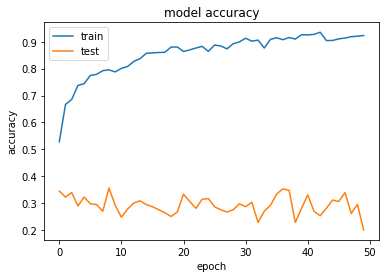

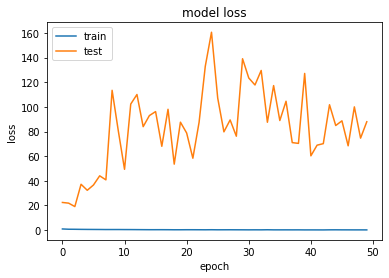

In [91]:
plot_hist(entirely_frozen_incepv3_history, 'entirely_frozen_incepV3')

#### saving the history of the fitting

In [92]:

with open(cwd + '/trainHistoryDict/basic_incepV3_history.p', 'wb') as file_pi:
        pickle.dump(entirely_frozen_incepv3_history.history, file_pi)
print('history saved')

history saved


## Few layers unfrozen

#### loading model

In [17]:
base_incepv3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(200, 200, 3),pooling=None)

87916544/87910968 [==============================] - 5s 0us/step


#### modifying slightly

In [0]:
# add a global spatial average pooling layer
x = base_incepv3.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 3 classes
predictions = Dense(3, activation='softmax')(x)

#### creating model object

In [0]:
# this is the model we will train
few_unfrozen_incepv3_model = Model(inputs=base_incepv3.input, outputs=predictions)

In [20]:
for layer in base_incepv3.layers:
    print(layer.name)
    layer.trainable = False

input_1
conv2d
batch_normalization
activation
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
max_pooling2d
conv2d_3
batch_normalization_3
activation_3
conv2d_4
batch_normalization_4
activation_4
max_pooling2d_1
conv2d_8
batch_normalization_8
activation_8
conv2d_6
conv2d_9
batch_normalization_6
batch_normalization_9
activation_6
activation_9
average_pooling2d
conv2d_5
conv2d_7
conv2d_10
conv2d_11
batch_normalization_5
batch_normalization_7
batch_normalization_10
batch_normalization_11
activation_5
activation_7
activation_10
activation_11
mixed0
conv2d_15
batch_normalization_15
activation_15
conv2d_13
conv2d_16
batch_normalization_13
batch_normalization_16
activation_13
activation_16
average_pooling2d_1
conv2d_12
conv2d_14
conv2d_17
conv2d_18
batch_normalization_12
batch_normalization_14
batch_normalization_17
batch_normalization_18
activation_12
activation_14
activation_17
activation_18
mixed1
conv2d_22
batch_normalization_22
activation_22
conv2d

#### calculating which layers to train

In [23]:
trainable_count = 0
per_layers = 0.2
num_model_layers = len(base_incepv3.layers)
starting_layer = int( num_model_layers * (1 - per_layers))
true_per_trained = (num_model_layers - starting_layer) / num_model_layers


print('true percentage of model trainable:', true_per_trained)

true percentage of model trainable: 0.20257234726688103


#### setting layers to train

In [0]:
#few_unfrozen_incepv3_model.trainable = True


set_trainable = False
for idx, layer in enumerate(base_incepv3.layers):
    if idx == starting_layer:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
        trainable_count += 1
    else:
        layer.trainable = False

#print('percent unfrozen:', trainable_count/ len(few_unfrozen_incepv3_model.layers) * 100 , '%')

In [26]:
for layer in few_unfrozen_incepv3_model.layers:
    print(layer.name,layer.trainable)

input_1 False
conv2d False
batch_normalization False
activation False
conv2d_1 False
batch_normalization_1 False
activation_1 False
conv2d_2 False
batch_normalization_2 False
activation_2 False
max_pooling2d False
conv2d_3 False
batch_normalization_3 False
activation_3 False
conv2d_4 False
batch_normalization_4 False
activation_4 False
max_pooling2d_1 False
conv2d_8 False
batch_normalization_8 False
activation_8 False
conv2d_6 False
conv2d_9 False
batch_normalization_6 False
batch_normalization_9 False
activation_6 False
activation_9 False
average_pooling2d False
conv2d_5 False
conv2d_7 False
conv2d_10 False
conv2d_11 False
batch_normalization_5 False
batch_normalization_7 False
batch_normalization_10 False
batch_normalization_11 False
activation_5 False
activation_7 False
activation_10 False
activation_11 False
mixed0 False
conv2d_15 False
batch_normalization_15 False
activation_15 False
conv2d_13 False
conv2d_16 False
batch_normalization_13 False
batch_normalization_16 False
activati

In [0]:
opt = tf.keras.optimizers.Adam(lr=0.001)
# compile the model (should be done *after* setting layers to non-trainable)
few_unfrozen_incepv3_model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

#### fitting the model

In [28]:
train_steps = int(len(df_train)/batch_size) #total trains set / batch_size
val_steps = int(len(df_val)/batch_size)

print('train steps:',train_steps)
print('val steps:',val_steps)

epochs = 50


model_filepath = 'few_unfrozen_incepv3.h5'
mcp = ModelCheckpoint(model_filepath, monitor='accuracy', save_best_only=True, mode='max')

# Train the model with validation 
few_unfrozen_incepv3_history = few_unfrozen_incepv3_model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks=[mcp])

train steps: 24
val steps: 3
Train for 24 steps, validate for 3 steps
Epoch 1/50
24/24 [==============================] - 954s 40s/step - loss: 0.7473 - accuracy: 0.6486 - val_loss: 136.6847 - val_accuracy: 0.3222
Epoch 2/50
24/24 [==============================] - 25s 1s/step - loss: 0.4801 - accuracy: 0.7882 - val_loss: 466.6744 - val_accuracy: 0.3167
Epoch 3/50
24/24 [==============================] - 24s 993ms/step - loss: 0.3190 - accuracy: 0.8580 - val_loss: 441.9021 - val_accuracy: 0.3167
Epoch 4/50
24/24 [==============================] - 25s 1s/step - loss: 0.2652 - accuracy: 0.8965 - val_loss: 1945.1142 - val_accuracy: 0.3167
Epoch 5/50
24/24 [==============================] - 24s 1s/step - loss: 0.1959 - accuracy: 0.9302 - val_loss: 2705.6225 - val_accuracy: 0.3167
Epoch 6/50
24/24 [==============================] - 24s 1s/step - loss: 0.1239 - accuracy: 0.9528 - val_loss: 2182.6768 - val_accuracy: 0.3167
Epoch 7/50
24/24 [==============================] - 21s 884ms/step - l

#### testing the model

In [29]:
test_steps = int(len(df_test)/batch_size)

metrics = few_unfrozen_incepv3_model.evaluate(test_dataset,
                   steps = test_steps)
print("model accuracy:",metrics[1])

3/3 [==============================] - 118s 39s/step - loss: 668.0733 - accuracy: 0.3444
model accuracy: 0.34444445


#### plotting training

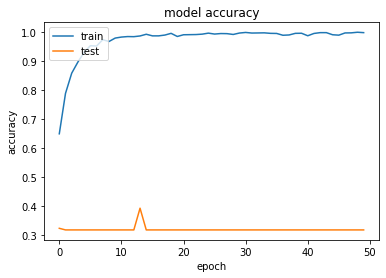

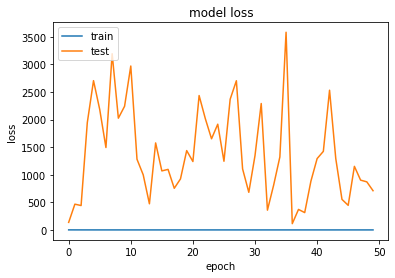

In [70]:
plot_hist(few_unfrozen_incepv3_history, 'few_unfrozen_incepV3')

#### saving the history of the fitting

In [39]:
with open(cwd + '/trainHistoryDict/few_unfrozen_incepv3_history.p', 'wb') as file_pi:
        pickle.dump(few_unfrozen_incepv3_history.history, file_pi)
print('history saved')

history saved


## Many layers unfrozen

#### loading model

In [0]:
base_incepv3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(200, 200, 3),pooling=None)

#### modifying slightly

In [0]:
# add a global spatial average pooling layer
x = base_incepv3.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 3 classes
predictions = Dense(3, activation='softmax')(x)

#### creating model object

In [0]:
# this is the model we will train
many_unfrozen_incepv3_model = Model(inputs=base_incepv3.input, outputs=predictions)

In [46]:
for layer in base_incepv3.layers:
    print(layer.name)
    layer.trainable = False

input_3
conv2d_188
batch_normalization_188
activation_188
conv2d_189
batch_normalization_189
activation_189
conv2d_190
batch_normalization_190
activation_190
max_pooling2d_8
conv2d_191
batch_normalization_191
activation_191
conv2d_192
batch_normalization_192
activation_192
max_pooling2d_9
conv2d_196
batch_normalization_196
activation_196
conv2d_194
conv2d_197
batch_normalization_194
batch_normalization_197
activation_194
activation_197
average_pooling2d_18
conv2d_193
conv2d_195
conv2d_198
conv2d_199
batch_normalization_193
batch_normalization_195
batch_normalization_198
batch_normalization_199
activation_193
activation_195
activation_198
activation_199
mixed0
conv2d_203
batch_normalization_203
activation_203
conv2d_201
conv2d_204
batch_normalization_201
batch_normalization_204
activation_201
activation_204
average_pooling2d_19
conv2d_200
conv2d_202
conv2d_205
conv2d_206
batch_normalization_200
batch_normalization_202
batch_normalization_205
batch_normalization_206
activation_200
activa

#### calculating which layers to train

In [47]:
trainable_count = 0
per_layers = 0.7
num_model_layers = len(base_incepv3.layers)
starting_layer = int( num_model_layers * (1 - per_layers))
true_per_trained = (num_model_layers - starting_layer) / num_model_layers


print('true percentage of model trainable:', true_per_trained)

true percentage of model trainable: 0.7009646302250804


#### setting which layers to train

In [0]:
set_trainable = False
for idx, layer in enumerate(base_incepv3.layers):
    if idx == starting_layer:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
        trainable_count += 1
    else:
        layer.trainable = False

In [49]:
for layer in many_unfrozen_incepv3_model.layers:
    print(layer.name,layer.trainable)

input_3 False
conv2d_188 False
batch_normalization_188 False
activation_188 False
conv2d_189 False
batch_normalization_189 False
activation_189 False
conv2d_190 False
batch_normalization_190 False
activation_190 False
max_pooling2d_8 False
conv2d_191 False
batch_normalization_191 False
activation_191 False
conv2d_192 False
batch_normalization_192 False
activation_192 False
max_pooling2d_9 False
conv2d_196 False
batch_normalization_196 False
activation_196 False
conv2d_194 False
conv2d_197 False
batch_normalization_194 False
batch_normalization_197 False
activation_194 False
activation_197 False
average_pooling2d_18 False
conv2d_193 False
conv2d_195 False
conv2d_198 False
conv2d_199 False
batch_normalization_193 False
batch_normalization_195 False
batch_normalization_198 False
batch_normalization_199 False
activation_193 False
activation_195 False
activation_198 False
activation_199 False
mixed0 False
conv2d_203 False
batch_normalization_203 False
activation_203 False
conv2d_201 False
c

In [0]:
opt = tf.keras.optimizers.Adam(lr=0.001)
# compile the model (should be done *after* setting layers to non-trainable)
many_unfrozen_incepv3_model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

#### fitting the model

In [51]:
train_steps = int(len(df_train)/batch_size) #total trains set / batch_size
val_steps = int(len(df_val)/batch_size)

print('train steps:',train_steps)
print('val steps:',val_steps)

epochs = 50


model_filepath = 'many_unfrozen_incepv3.h5'
mcp = ModelCheckpoint(model_filepath, monitor='accuracy', save_best_only=True, mode='max')

# Train the model with validation 
many_unfrozen_incepv3_history = many_unfrozen_incepv3_model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks=[mcp])

train steps: 24
val steps: 3
Train for 24 steps, validate for 3 steps
Epoch 1/50
24/24 [==============================] - 45s 2s/step - loss: 0.7635 - accuracy: 0.6514 - val_loss: 3744.3074 - val_accuracy: 0.3278
Epoch 2/50
24/24 [==============================] - 35s 1s/step - loss: 0.5227 - accuracy: 0.7726 - val_loss: 91330.2161 - val_accuracy: 0.3278
Epoch 3/50
24/24 [==============================] - 35s 1s/step - loss: 0.4426 - accuracy: 0.8111 - val_loss: 654572.0417 - val_accuracy: 0.3278
Epoch 4/50
24/24 [==============================] - 36s 1s/step - loss: 0.4126 - accuracy: 0.8184 - val_loss: 17969.9531 - val_accuracy: 0.3278
Epoch 5/50
24/24 [==============================] - 31s 1s/step - loss: 0.3866 - accuracy: 0.8170 - val_loss: 4118.6772 - val_accuracy: 0.3278
Epoch 6/50
24/24 [==============================] - 35s 1s/step - loss: 0.3664 - accuracy: 0.8313 - val_loss: 2533.7860 - val_accuracy: 0.3278
Epoch 7/50
24/24 [==============================] - 35s 1s/step - lo

#### testing the model

In [52]:
test_steps = int(len(df_test)/batch_size)

metrics = many_unfrozen_incepv3_model.evaluate(test_dataset,
                   steps = test_steps)
print("model accuracy:",metrics[1])

3/3 [==============================] - 2s 720ms/step - loss: 6973.3055 - accuracy: 0.2917
model accuracy: 0.29166666


#### plotting training

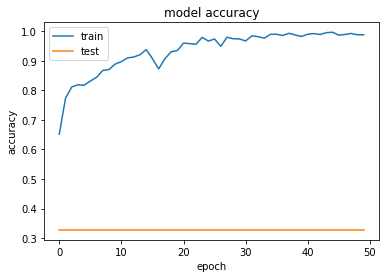

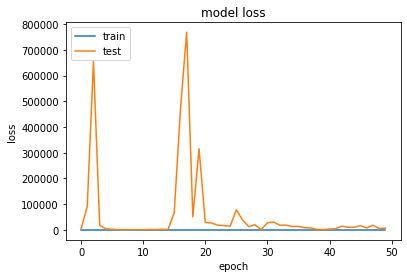

In [71]:
plot_hist(many_unfrozen_incepv3_history, 'many_unfrozen_incepV3')

#### saving the history of the fitting

In [54]:
with open(cwd + '/trainHistoryDict/many_unfrozen_incepv3_history.p', 'wb') as file_pi:
        pickle.dump(many_unfrozen_incepv3_history.history, file_pi)
print('history saved')

history saved


## entirely unfrozen

In [0]:
base_incepv3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(200, 200, 3),pooling=None)

#### modifying slightly

In [0]:
# add a global spatial average pooling layer
x = base_incepv3.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 3 classes
predictions = Dense(3, activation='softmax')(x)

#### creating model object

In [0]:
# this is the model we will train
unfrozen_incepv3_model = Model(inputs=base_incepv3.input, outputs=predictions)

In [76]:
for layer in unfrozen_incepv3_model.layers:
    print(layer.name)
    layer.trainable = True

input_5
conv2d_376
batch_normalization_376
activation_376
conv2d_377
batch_normalization_377
activation_377
conv2d_378
batch_normalization_378
activation_378
max_pooling2d_16
conv2d_379
batch_normalization_379
activation_379
conv2d_380
batch_normalization_380
activation_380
max_pooling2d_17
conv2d_384
batch_normalization_384
activation_384
conv2d_382
conv2d_385
batch_normalization_382
batch_normalization_385
activation_382
activation_385
average_pooling2d_36
conv2d_381
conv2d_383
conv2d_386
conv2d_387
batch_normalization_381
batch_normalization_383
batch_normalization_386
batch_normalization_387
activation_381
activation_383
activation_386
activation_387
mixed0
conv2d_391
batch_normalization_391
activation_391
conv2d_389
conv2d_392
batch_normalization_389
batch_normalization_392
activation_389
activation_392
average_pooling2d_37
conv2d_388
conv2d_390
conv2d_393
conv2d_394
batch_normalization_388
batch_normalization_390
batch_normalization_393
batch_normalization_394
activation_388
acti

In [77]:
for layer in unfrozen_incepv3_model.layers:
    print(layer.name,' Trainable =',layer.trainable)

input_5  Trainable = True
conv2d_376  Trainable = True
batch_normalization_376  Trainable = True
activation_376  Trainable = True
conv2d_377  Trainable = True
batch_normalization_377  Trainable = True
activation_377  Trainable = True
conv2d_378  Trainable = True
batch_normalization_378  Trainable = True
activation_378  Trainable = True
max_pooling2d_16  Trainable = True
conv2d_379  Trainable = True
batch_normalization_379  Trainable = True
activation_379  Trainable = True
conv2d_380  Trainable = True
batch_normalization_380  Trainable = True
activation_380  Trainable = True
max_pooling2d_17  Trainable = True
conv2d_384  Trainable = True
batch_normalization_384  Trainable = True
activation_384  Trainable = True
conv2d_382  Trainable = True
conv2d_385  Trainable = True
batch_normalization_382  Trainable = True
batch_normalization_385  Trainable = True
activation_382  Trainable = True
activation_385  Trainable = True
average_pooling2d_36  Trainable = True
conv2d_381  Trainable = True
conv

#### setting the optimizer

In [0]:
opt = tf.keras.optimizers.Adam(lr=0.001)

# compile the model (should be done *after* setting layers to non-trainable)
unfrozen_incepv3_model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

#### fitting the model

In [79]:
train_steps = int(len(df_train)/batch_size) #total trains set / batch_size
val_steps = int(len(df_val)/batch_size)

print('train steps:',train_steps)
print('val steps:',val_steps)

epochs = 50


model_filepath = 'unfrozen_incepv3.h5'
mcp = ModelCheckpoint(model_filepath, monitor='accuracy', save_best_only=True, mode='max')

# Train the model with validation 
unfrozen_incepv3_history = unfrozen_incepv3_model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks=[mcp])

train steps: 24
val steps: 3
Train for 24 steps, validate for 3 steps
Epoch 1/50
24/24 [==============================] - 60s 2s/step - loss: 0.7623 - accuracy: 0.6559 - val_loss: 352.7146 - val_accuracy: 0.3167
Epoch 2/50
24/24 [==============================] - 52s 2s/step - loss: 0.5536 - accuracy: 0.7549 - val_loss: 651.3600 - val_accuracy: 0.3167
Epoch 3/50
24/24 [==============================] - 52s 2s/step - loss: 0.4899 - accuracy: 0.7882 - val_loss: 4545.3030 - val_accuracy: 0.3528
Epoch 4/50
24/24 [==============================] - 52s 2s/step - loss: 0.4565 - accuracy: 0.7979 - val_loss: 6.5605 - val_accuracy: 0.3167
Epoch 5/50
24/24 [==============================] - 53s 2s/step - loss: 0.4333 - accuracy: 0.8038 - val_loss: 1.1570 - val_accuracy: 0.2778
Epoch 6/50
24/24 [==============================] - 54s 2s/step - loss: 0.4139 - accuracy: 0.8080 - val_loss: 0.8908 - val_accuracy: 0.5333
Epoch 7/50
24/24 [==============================] - 52s 2s/step - loss: 0.3890 - ac

#### testing the model

In [80]:
test_steps = int(len(df_test)/batch_size)

metrics = unfrozen_incepv3_model.evaluate(test_dataset,
                   steps = test_steps)
print("model accuracy:",metrics[1])

3/3 [==============================] - 3s 841ms/step - loss: 1.4283 - accuracy: 0.8056
model accuracy: 0.8055556


#### plotting training

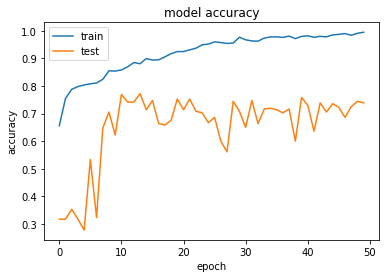

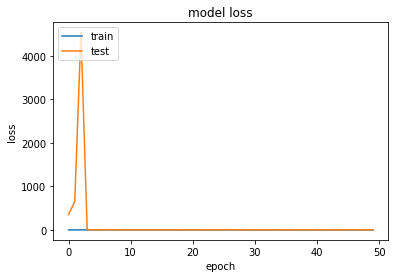

In [81]:
plot_hist(unfrozen_incepv3_history, 'unfrozen_incepV3')

#### saving the history of the fitting

In [82]:
with open(cwd + '/trainHistoryDict/unfrozen_incepv3_history.p', 'wb') as file_pi:
        pickle.dump(unfrozen_incepv3_history.history, file_pi)
print('history saved')

history saved
